In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.stats import permutation_test, false_discovery_control, spearmanr
import pybedtools

from warnings import filterwarnings
filterwarnings("ignore", category=pd.errors.DtypeWarning)
filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#set up paths
#=========================
workdir = '/home/AD/rkgadde/L1IP'
annotation = f'{workdir}/hg38_data/annotations/gencode.v46.basic.annotation.sorted.genes.gff3'
celltypes = f'{workdir}/celltypes.txt'

genedir = f'{workdir}/gene_data'
figdir = f'{workdir}/results/CZI/plots'


# Load in data

In [320]:
me_type = 'L1'
abs_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_abs.tsv'
ins_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_ins.tsv'

abs_df = pd.read_csv(abs_file, sep='\t', usecols=[0,1,2,3,4,5,6,7,8], names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])
abs_df['me_type'] = 'absence'
ins_df = pd.read_csv(ins_file, sep='\t', usecols=[0,1,2,3,4,5,6, 7,8],  names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])
ins_df['me_type'] = 'insertion'
l1_df = pd.concat([abs_df, ins_df])
l1_df['length'] = l1_df['end'] - l1_df['start']
emp_ = np.empty(len(l1_df)).astype(str)
emp_.fill('both')
emp_[l1_df['het'].isna()] = 'hom'
emp_[l1_df['hom'].isna()] = 'het'
l1_df['genotype'] = emp_


me_type = 'Alu'
abs_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_abs.tsv'
ins_file = f'{workdir}/mC_data/CZI/type/vars/all_{me_type}_ins.tsv'

abs_df = pd.read_csv(abs_file, sep='\t', usecols=[0,1,2,3,4,5,6,7,8], names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])
abs_df['me_type'] = 'absence'
ins_df = pd.read_csv(ins_file, sep='\t', usecols=[0,1,2,3,4,5,6, 7,8],  names=['chrom','start','end','id', 'length', 'strand', 'class', 'het', 'hom'])
ins_df['me_type'] = 'insertion'
alu_df = pd.concat([abs_df, ins_df])
alu_df['length'] = alu_df['end'] - alu_df['start']
emp_ = np.empty(len(alu_df)).astype(str)
emp_.fill('both')
emp_[alu_df['het'].isna()] = 'hom'
emp_[alu_df['hom'].isna()] = 'het'
emp_[(alu_df['hom'].isna()) & (alu_df['het'].isna())] = 'both'
alu_df['genotype'] = emp_


alu_bt = pybedtools.BedTool.from_dataframe(alu_df)
l1_bt = pybedtools.BedTool.from_dataframe(l1_df)

cgi_df = pd.read_csv('/cndd3/dburrows/DATA/annotations/gencode/gencode.v37.CGI.hg38.jofan.bed', sep='\t',header=None)
all_df = pd.read_csv('/cndd3/dburrows/DATA/annotations/gencode/red.bed', sep='\t',header=None)
# intron_df=all_df[all_df[3].str.contains('intron')]
# nonintron_df=all_df[~all_df[3].str.contains('intron')]
cgi_bt = pybedtools.BedTool.from_dataframe(cgi_df)
all_bt = pybedtools.BedTool.from_dataframe(all_df)

# plot basic statistics of MEs

In [202]:
curr = alu_df.copy()
index = curr[(curr['het'].isna()) & (curr['hom'].isna())].index
curr.drop(index=index, inplace=True)
curr.reset_index(drop=True, inplace=True)
count=0
new_df = pd.DataFrame()
for i in range(len(curr)):
    if type(curr['het'][i]) == str:
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['het'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['het'][i].split(',')
        rep['genotype_sample'] = np.repeat('het', len(rep))
        new_df = pd.concat([new_df, rep])

    if type(curr['hom'][i]) == str:
        count+=1
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['hom'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['hom'][i].split(',')
        rep['genotype_sample'] = np.repeat('het', len(rep))
        new_df = pd.concat([new_df, rep])

alu_samp_df = new_df.copy()
alu_samp_df['age'] = [i[0] for i in alu_samp_df['sample']]
alu_samp_df['sex'] = [i[1] for i in alu_samp_df['sample']]


In [207]:
#plot statistics of donors
#=============================

#Breakdown by sample first
#============================
# combine alu
curr = alu_df.copy()
index = curr[(curr['het'].isna()) & (curr['hom'].isna())].index
curr.drop(index=index, inplace=True)
curr.reset_index(drop=True, inplace=True)

new_df = pd.DataFrame()
for i in range(len(curr)):
    if type(curr['het'][i]) == str:
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['het'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['het'][i].split(',')
        rep['genotype_sample'] = np.repeat('het', len(rep))
        new_df = pd.concat([new_df, rep])

    if type(curr['hom'][i]) == str:
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['hom'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['hom'][i].split(',')
        rep['genotype_sample'] = np.repeat('hom', len(rep))
        new_df = pd.concat([new_df, rep])

alu_samp_df = new_df.copy()
alu_samp_df['age'] = [i[0] for i in alu_samp_df['sample']]
alu_samp_df['sex'] = [i[1] for i in alu_samp_df['sample']]

# combine l1
curr = l1_df.copy()
index = curr[(curr['het'].isna()) & (curr['hom'].isna())].index
curr.drop(index=index, inplace=True)
curr.reset_index(drop=True, inplace=True)

new_df = pd.DataFrame()
for i in range(len(curr)):
    geno_l = []
    if type(curr['het'][i]) == str:
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['het'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['het'][i].split(',')
        rep['genotype_sample'] = np.repeat('het', len(rep))
        new_df = pd.concat([new_df, rep])

    if type(curr['hom'][i]) == str:
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['hom'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['hom'][i].split(',')
        rep['genotype_sample'] = np.repeat('hom', len(rep))
        new_df = pd.concat([new_df, rep])

l1_samp_df = new_df.copy()
l1_samp_df['age'] = [i[0] for i in l1_samp_df['sample']]
l1_samp_df['sex'] = [i[1] for i in l1_samp_df['sample']]

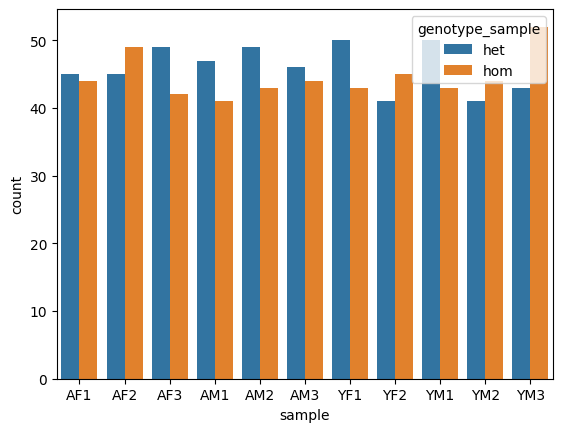

In [208]:
#plot l1
plot_df = pd.DataFrame(l1_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='absence'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

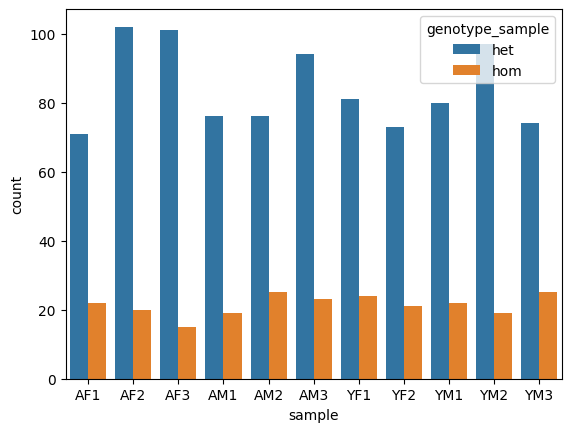

In [209]:
#plot l1
plot_df = pd.DataFrame(l1_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='insertion'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

In [198]:
alu_samp_df['genotype_sample'].unique()

array(['het'], dtype=object)

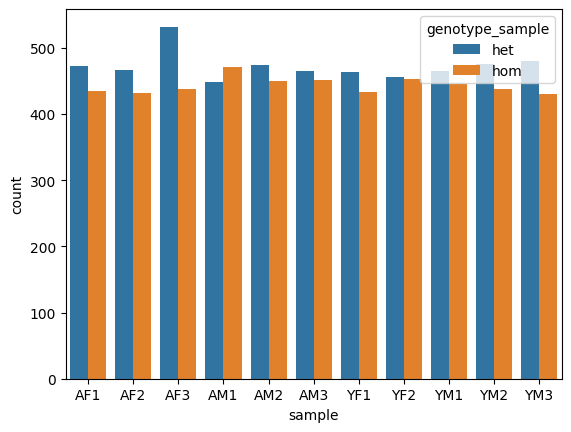

In [210]:
#plot alu
plot_df = pd.DataFrame(alu_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='absence'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

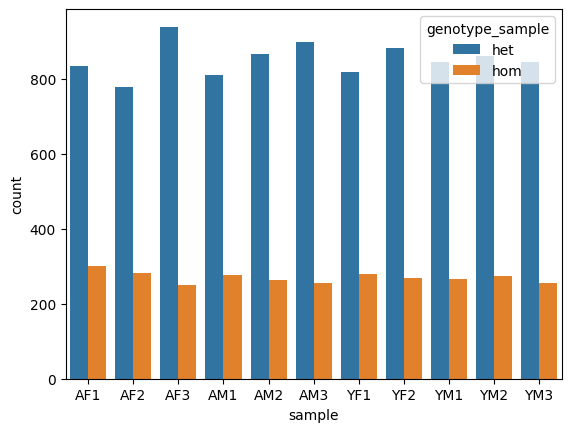

In [211]:
#plot alu
plot_df = pd.DataFrame(alu_samp_df.groupby(['sample', 'me_type', 'genotype_sample']).count()['chrom'])
plot_df.rename(columns={'chrom':'count'}, inplace=True)
plot_df.reset_index(inplace=True)
sns.barplot(data=plot_df[plot_df['me_type']=='insertion'], x ='sample', y = 'count', hue = 'genotype_sample')
plt.show()

# Compute intersection

In [220]:
#compute intersection
l1_cgi = l1_bt.intersect(cgi_bt, f=0.3, wo=True) 
alu_cgi = alu_bt.intersect(cgi_bt, f=0.3, wo=True) 
alu_all = alu_bt.intersect(all_bt, f=0.3, wo=True) 
l1_all = all_bt.intersect(l1_bt, f=0.3, wo=True) 

l1_cgi_df = l1_cgi.to_dataframe(disable_auto_names=True, header=None)
l1_cgi_df.rename(columns={7: 'het', 8: 'hom', 9: 'me_type', 10: 'genotype', 14: 'region', 18: 'length'}, inplace=True)
alu_cgi_df = alu_cgi.to_dataframe(disable_auto_names=True, header=None)
alu_cgi_df.rename(columns={7: 'het', 8: 'hom', 9: 'me_type', 10: 'genotype', 14: 'region', 18: 'length'}, inplace=True)
alu_all_df = alu_all.to_dataframe(disable_auto_names=True, header=None)
alu_all_df.rename(columns={7: 'het', 8: 'hom', 9: 'me_type', 10: 'genotype', 14: 'region', 17: 'length'}, inplace=True)
l1_all_df = l1_all.to_dataframe(disable_auto_names=True, header=None)
l1_all_df.rename(columns={13: 'het', 14: 'hom', 15: 'me_type', 16: 'genotype', 3: 'region', 17: 'length'}, inplace=True)

In [329]:
alu_df

,chrom,start,end,id,length,strand,class,het,hom,me_type,genotype
0,chr1,2994983,2995286,CZI_abs_0,303,+,AluYg6,"AF2,YF1,YM1",NaN,absence,het
1,chr1,4095098,4095400,CZI_abs_1,302,-,AluYb8,"AF3,AM1,AM2,YF1,YF2,YM1,YM3",NaN,absence,het
2,chr1,236431638,236431950,CZI_abs_100,312,+,AluYb8,"AF2,AM1,AM2,AM3,YF1,YF2,YM1,YM3","AF1,YM2",absence,both
3,chr4,177235682,177236005,CZI_abs_1000,323,-,AluYb8,"AF3,YM1,YM2","AF1,AF2,AM1,AM2,AM3,YF1,YF2,YM3",absence,both
4,chr4,177593102,177593409,CZI_abs_1001,307,+,AluYb8,"AF1,AF2,AF3,AM2,YF1,YM1","AM1,AM3,YF2,YM2,YM3",absence,both
...,...,...,...,...,...,...,...,...,...,...,...
3173,chr9,124088197,124088200,CZI_ins_4331,3,-,AluSz6,"AF2,AM2,YM3",NaN,insertion,het
3174,chr9,126217880,126217897,CZI_ins_4333,17,+,AluYc,"AF1,AF2,AF3,YF2,YM2","AM2,AM3,YF1,YM3",insertion,both
3175,chr9,127834834,127834845,CZI_ins_4334,11,-,AluYa5,YM3,NaN,insertion,het
3176,chr9,129426079,129426094,CZI_ins_4335,15,-,AluYm1,"AF1,AF2,AF3,AM1,AM2,AM3,YF1,YF2,YM1,YM2,YM3",NaN,insertion,het


In [350]:
# do shuffle test
reg_names = np.append(all_df[3].unique(), cgi_df[3].unique())
#randomly shuffle
value_l, class_l, reg_l = [],[],[]
tot_df = pd.DataFrame()
for it in range(100):
    print(it)
    #redo with actual chromosome positions
    alushuff_df = pd.DataFrame()
    for ch in alu_df['chrom'].unique():
        curr = alu_df[alu_df['chrom'] == ch].copy()
        mini = 0
        maxi = np.max(curr['end'])
        length = curr['end'].values - curr['start'].values
        new_start = np.random.randint(mini, maxi - length) 
        new_end = new_start+length
        curr['start'] = new_start
        curr['end'] = new_end
        alushuff_df = pd.concat([alushuff_df, curr])
    
    l1shuff_df = pd.DataFrame()
    for ch in l1_df['chrom'].unique():
        curr = l1_df[l1_df['chrom'] == ch].copy()
        mini = 0
        maxi = np.max(curr['end'])
        length = curr['end'].values - curr['start'].values
        new_start = np.random.randint(mini, maxi - length)
        new_end = new_start+length
        curr['start'] = new_start
        curr['end'] = new_end
        l1shuff_df = pd.concat([l1shuff_df, curr])
    
    alushuff_bt = pybedtools.BedTool.from_dataframe(alushuff_df)
    l1shuff_bt = pybedtools.BedTool.from_dataframe(l1shuff_df)
    
    l1shuff_cgi = l1shuff_bt.intersect(cgi_bt, f=0.3, wo=True) 
    alushuff_cgi = alushuff_bt.intersect(cgi_bt, f=0.3, wo=True) 
    alushuff_all = alushuff_bt.intersect(all_bt, f=0.3, wo=True) 
    l1shuff_all = all_bt.intersect(l1shuff_bt, f=0.3, wo=True) 

    l1shuff_cgi_df = l1shuff_cgi.to_dataframe(disable_auto_names=True, header=None)
    alushuff_cgi_df = alushuff_cgi.to_dataframe(disable_auto_names=True, header=None)
    alushuff_all_df = alushuff_all.to_dataframe(disable_auto_names=True, header=None)
    l1shuff_all_df = l1shuff_all.to_dataframe(disable_auto_names=True, header=None)

    if len(l1shuff_cgi_df) > 0: l1_out = pd.concat([l1shuff_cgi_df.groupby(13).count()[0],l1shuff_all_df.groupby(3).count()[0]])
    else: l1_out = pd.DataFrame(l1shuff_all_df.groupby(3).count()[0])
    alu_out = pd.concat([alushuff_cgi_df.groupby(14).count()[0],alushuff_all_df.groupby(14).count()[0]])
    l1_out = l1_out.reindex(reg_names, fill_value=0).reset_index()
    alu_out = alu_out.reindex(reg_names, fill_value=0).reset_index()
    l1_out['class'] = 'l1'
    alu_out['class'] = 'alu'
    l1_out.rename(columns={'index':'region', 0:'count'}, inplace=True)
    alu_out.rename(columns={14:'region', 0:'count'}, inplace=True)
    comb_df = pd.concat([l1_out, alu_out])
    tot_df = pd.concat([tot_df, comb_df])

0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [351]:
tot_df

,region,count,class
0,transcript_TSS+-1k,17,l1
1,exon_1st,21,l1
2,exon,52,l1
3,5utr,30,l1
4,exon_lncRNA,9,l1
...,...,...,...
10,intron_proteincoding,1886,alu
11,cds,46,alu
12,cpgIslandExt,25,alu
13,cpgShore_up,71,alu


In [346]:
if len(l1shuff_cgi_df) > 0: l1_out = pd.concat([l1shuff_cgi_df.groupby(13).count()[0],l1shuff_all_df.groupby(3).count()[0]])
else: l1_out = pd.DataFrame(l1shuff_all_df.groupby(3).count()[0])
alu_out = pd.concat([alushuff_cgi_df.groupby(14).count()[0],alushuff_all_df.groupby(14).count()[0]])
l1_out = l1_out.reindex(reg_names, fill_value=0).reset_index()
alu_out = alu_out.reindex(reg_names, fill_value=0).reset_index()
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
l1_out.rename(columns={'index':'region', 0:'count'}, inplace=True)
alu_out.rename(columns={14:'region', 0:'count'}, inplace=True)
comb_df = pd.concat([l1_out, alu_out])
tot_df = pd.concat([tot_df, comb_df])

In [349]:
comb_df

,region,count,class
0,transcript_TSS+-1k,6,l1
1,exon_1st,6,l1
2,exon,19,l1
3,5utr,3,l1
4,exon_lncRNA,2,l1
5,3utr,6,l1
6,intron,15,l1
7,intron_1st,5,l1
8,intron_lncRNA,2,l1
9,exon_proteincoding,17,l1


In [334]:
pd.concat([l1shuff_cgi_df.groupby(14).count()[0],l1shuff_all_df.groupby(3).count()[0]])

cpgIslandExt             6
cpgShore_down            7
cpgShore_up              6
3utr                     6
5utr                     3
cds                     15
exon                    19
exon_1st                 6
exon_lncRNA              2
exon_proteincoding      17
intron                  15
intron_1st               5
intron_lncRNA            2
intron_proteincoding    14
transcript_TSS+-1k       6
Name: 0, dtype: int64

In [321]:
#plot number of intersections by genotype, insertion type, length, region

#combine together intersected labelled data
#===========================================
l1_out = pd.concat([l1_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    l1_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])

alu_out = pd.concat([alu_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    alu_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
comb_df = pd.concat([l1_out, alu_out])

curr = comb_df.copy()
index = curr[(curr['het'].isna()) & (curr['hom'].isna())].index
curr.reset_index(drop=True, inplace=True)

new_df = pd.DataFrame()
for i in range(len(curr)):
    if curr['het'][i] != '.':
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['het'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['het'][i].split(',')
        rep['genotype_sample'] = np.repeat('het', len(rep))
        new_df = pd.concat([new_df, rep])

    if curr['hom'][i] != '.':
        rep = pd.concat([pd.DataFrame(curr.loc[i]).T] * len(curr['hom'][i].split(',')), ignore_index=True)
        rep['sample'] = curr['hom'][i].split(',')
        rep['genotype_sample'] = np.repeat('hom', len(rep))
        new_df = pd.concat([new_df, rep])

comb_int_df = new_df

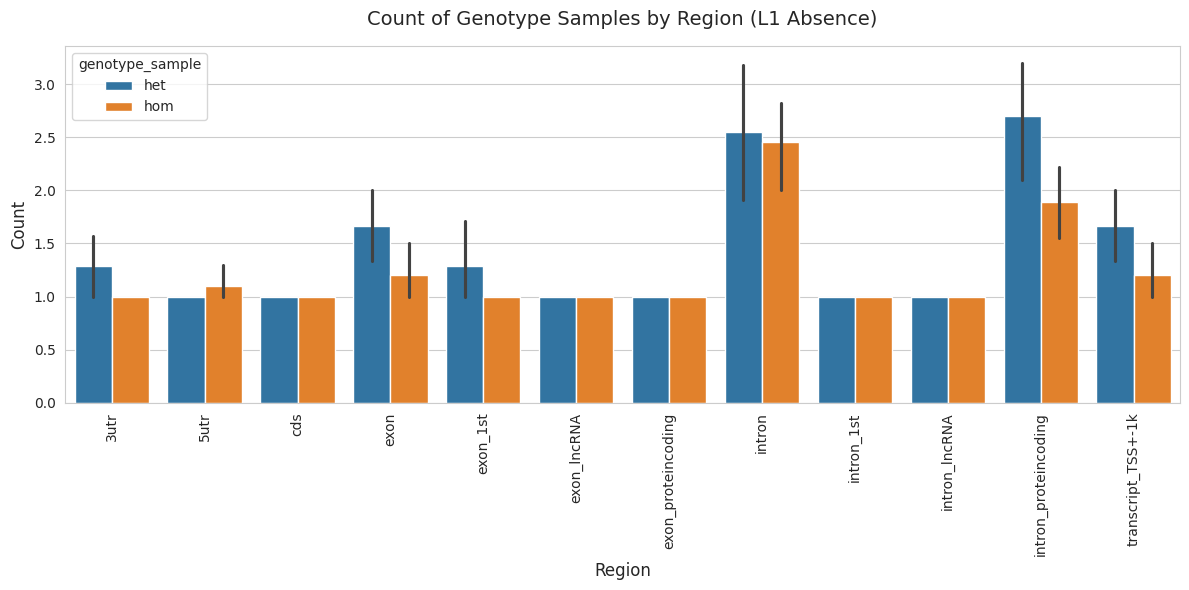

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'absence') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 Absence)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


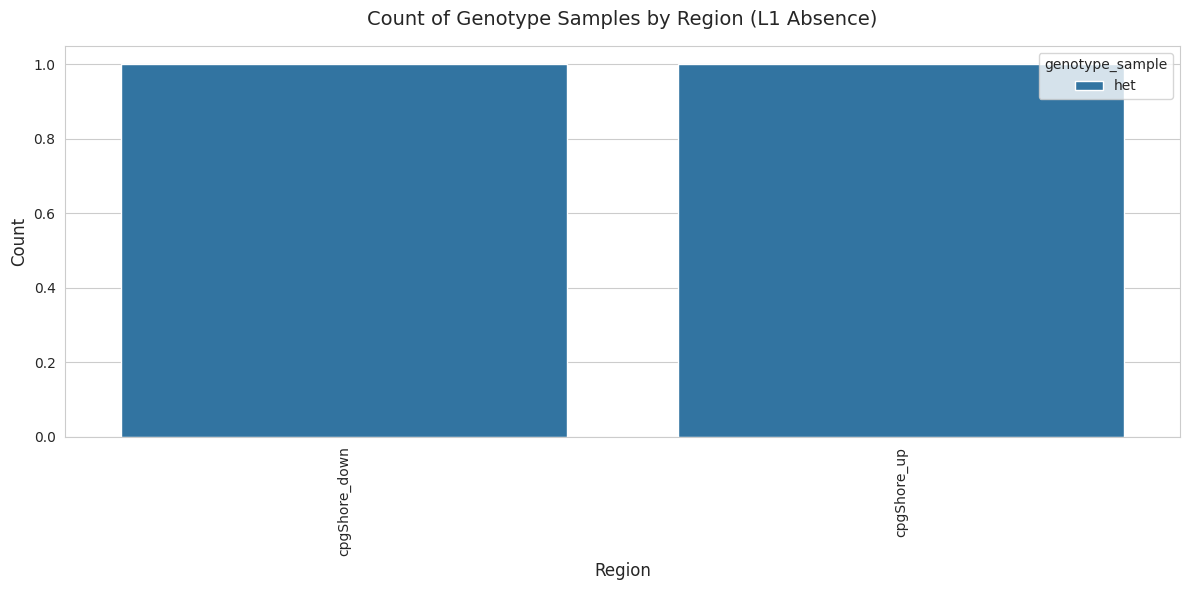

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'insertion') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 Absence)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


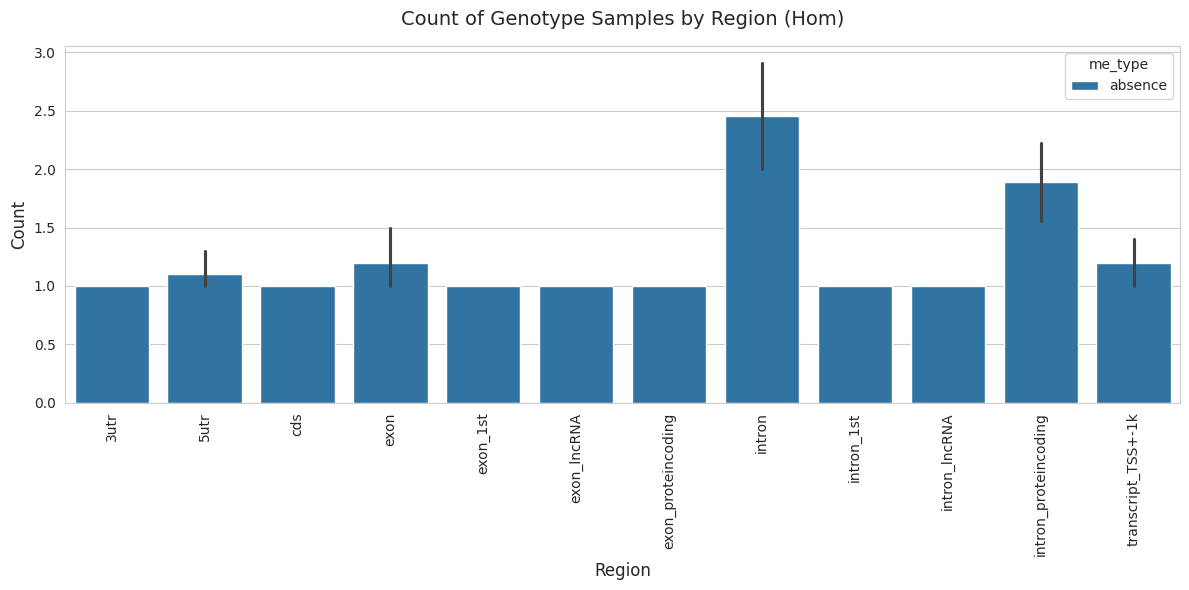

In [302]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'hom') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Hom)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


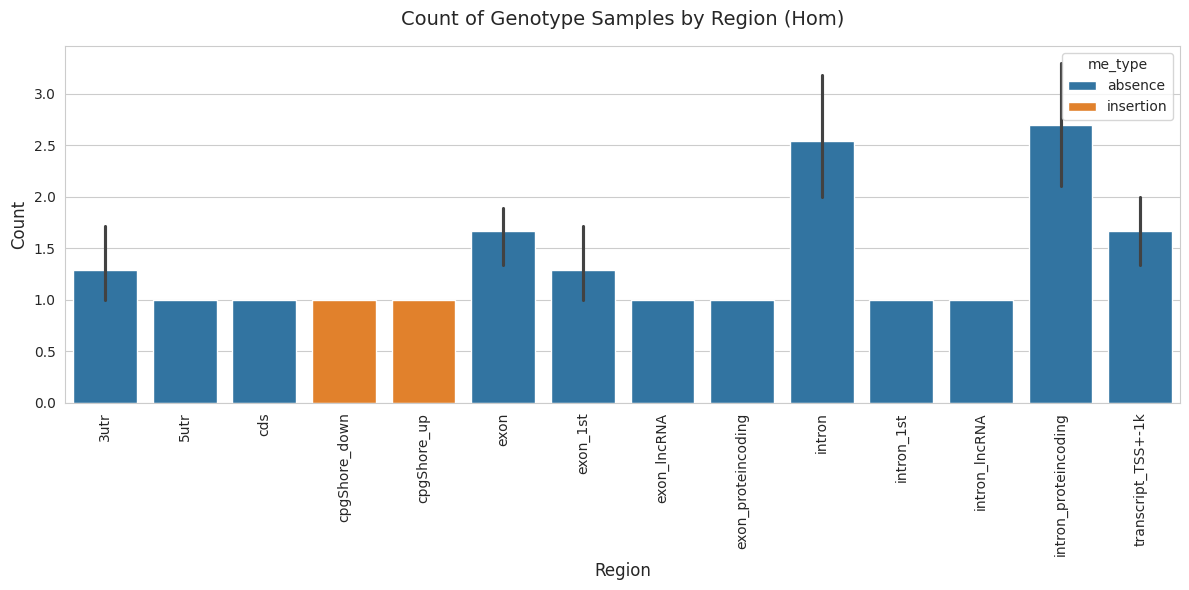

In [303]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'het') & (plot_df['class'] == 'l1')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Hom)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


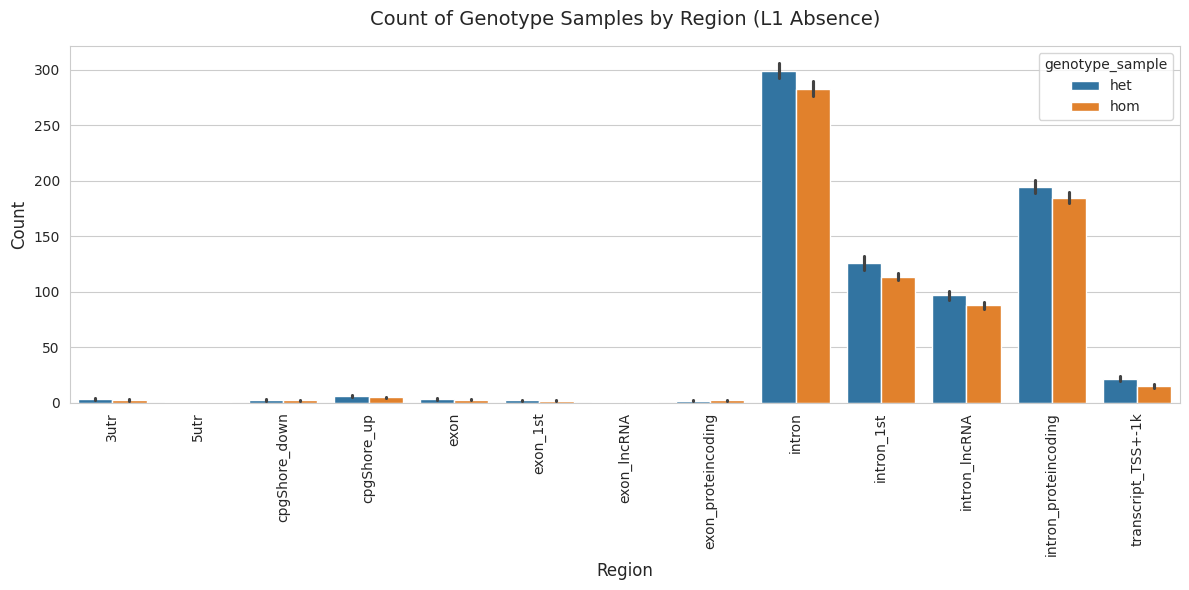

In [296]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'absence') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 Absence)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


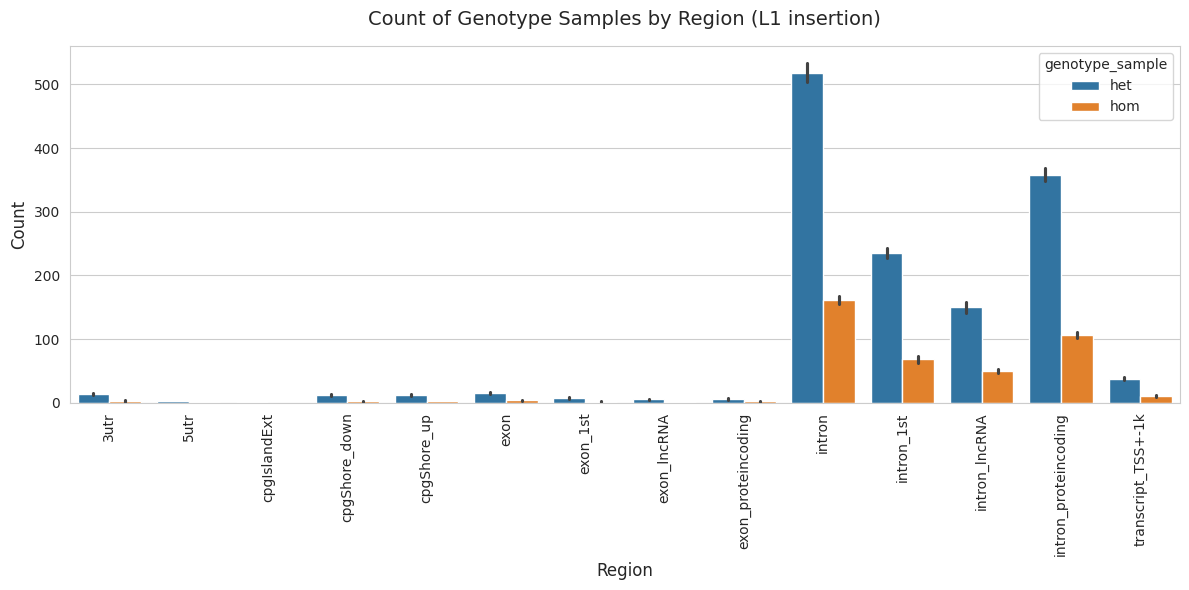

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['me_type'] == 'insertion') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='genotype_sample'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (L1 insertion)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


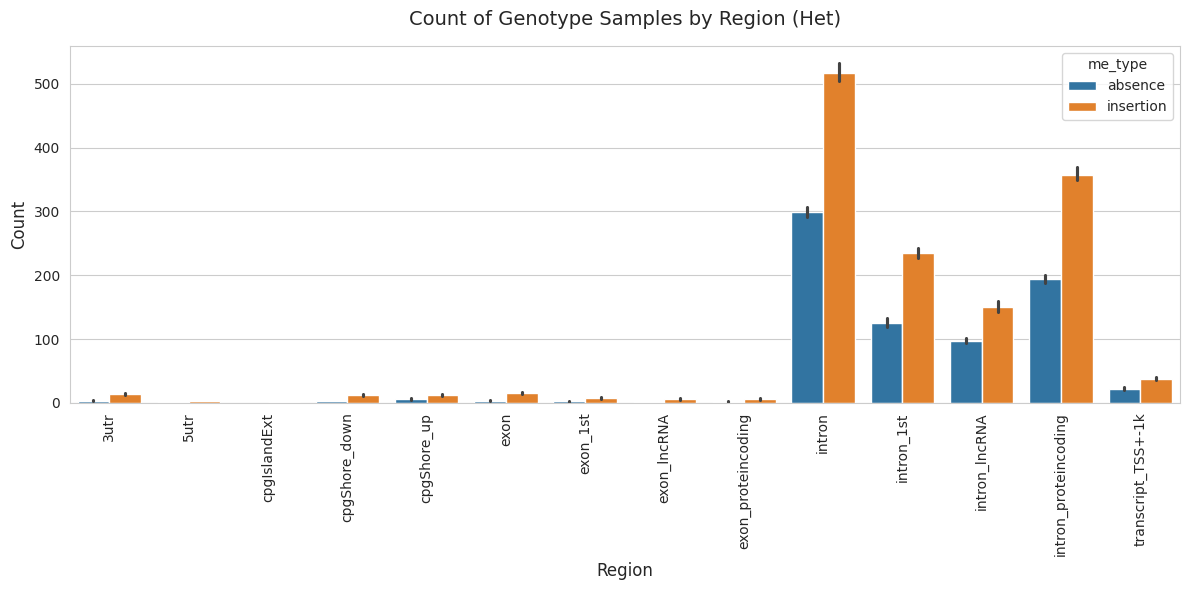

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'het') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Het)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


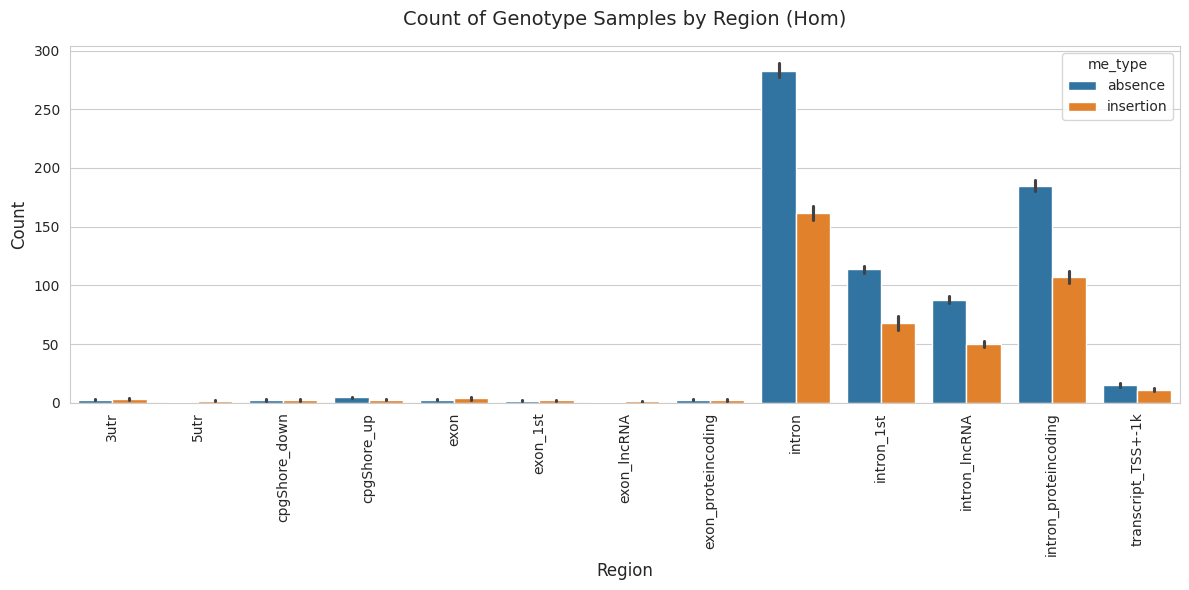

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot DataFrame (from your example)
plot_df = pd.DataFrame(comb_int_df.groupby(['region', 'me_type', 'genotype_sample', 'sample', 'class']).count()['het'])
plot_df.rename(columns={'het': 'count'}, inplace=True)
plot_df.reset_index(inplace=True)

# Set plot size and style
plt.figure(figsize=(12, 6))  # Increase plot size (width, height)
sns.set_style("whitegrid")  # Use a clean aesthetic style

# Create the barplot
sns.barplot(
    data=plot_df[(plot_df['genotype_sample'] == 'hom') & (plot_df['class'] == 'alu')],
    x='region', y='count', hue='me_type'
)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add a title and axis labels for better visualization
plt.title('Count of Genotype Samples by Region (Hom)', fontsize=14, pad=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()


In [305]:
l1_out = pd.concat([l1_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    l1_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])

alu_out = pd.concat([alu_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    alu_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
comb_df = pd.concat([l1_out, alu_out])
comb_df

,me_type,region,het,hom,genotype,length,class
0,insertion,cpgShore_up,"AF3,YM3",.,het,15,l1
1,insertion,cpgShore_down,"AF2,AF3,AM2,YF1,YM1,YM2",.,het,2,l1
2,insertion,cpgShore_up,AF1,.,het,9,l1
0,absence,intron_proteincoding,"AM3,YF2,YM1,YM3","AF1,AF2,AF3,AM2",both,3041,l1
1,absence,intron,"AM3,YF2,YM1,YM3","AF1,AF2,AF3,AM2",both,3041,l1
...,...,...,...,...,...,...,...
7202,insertion,intron,"AF2,AF3,AM2,YF2,YM1,YM2,YM3",.,het,20,alu
7203,insertion,intron_lncRNA,"AF2,AF3,AM2,YF2,YM1,YM2,YM3",.,het,20,alu
7204,insertion,intron_1st,"AF2,AF3,AM2,YF2,YM1,YM2,YM3",.,het,20,alu
7205,insertion,intron_proteincoding,YM3,.,het,11,alu


In [319]:
l1_out = pd.concat([l1_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    l1_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])

alu_out = pd.concat([alu_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    alu_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
comb_df = pd.concat([l1_out, alu_out])
comb_df= pd.DataFrame(comb_df.groupby(['region', 'class']).count()['me_type'])
comb_df
comb_df.reset_index(inplace=True)

,region,class,me_type
0,3utr,alu,62
1,3utr,l1,2
2,5utr,alu,14
3,5utr,l1,2
4,cds,l1,1
5,cpgIslandExt,alu,2
6,cpgShore_down,alu,49
7,cpgShore_down,l1,1
8,cpgShore_up,alu,57
9,cpgShore_up,l1,2


In [323]:
comb_df[(comb_df['region' ]== reg) & (comb_df['class'] == i)]

,region,class,me_type
8,cpgShore_up,alu,57


In [326]:
#combined
#===========
l1_out = pd.concat([l1_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    l1_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])

alu_out = pd.concat([alu_cgi_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']], 
                    alu_all_df[['me_type', 'region', 'het', 'hom', 'genotype', 'length']]])
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
comb_df = pd.concat([l1_out, alu_out])
comb_df= pd.DataFrame(comb_df.groupby(['region', 'class']).count()['me_type'])
comb_df.reset_index(inplace=True)
comb_df.rename(columns={'me_type':'count'}, inplace=True)

stat_region, stat_sig, stat_fc, stat_class = [],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:
        observed_overlap = comb_df[(comb_df['region' ]== reg) & (comb_df['class'] == i)]['count'].values[0]
        expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)]['count'].values)
        from scipy.stats import fisher_exact
        no_overlap_observed = total_observed - observed_overlap
        no_overlap_expected = total_observed - expected_overlap
        # Contingency table
        contingency_table = [
            [observed_overlap, no_overlap_observed],  # Observed
            [expected_overlap, no_overlap_expected]  # Expected
        ]
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')
        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2(observed_overlap/expected_overlap))

NameError: name 'tot_df' is not defined

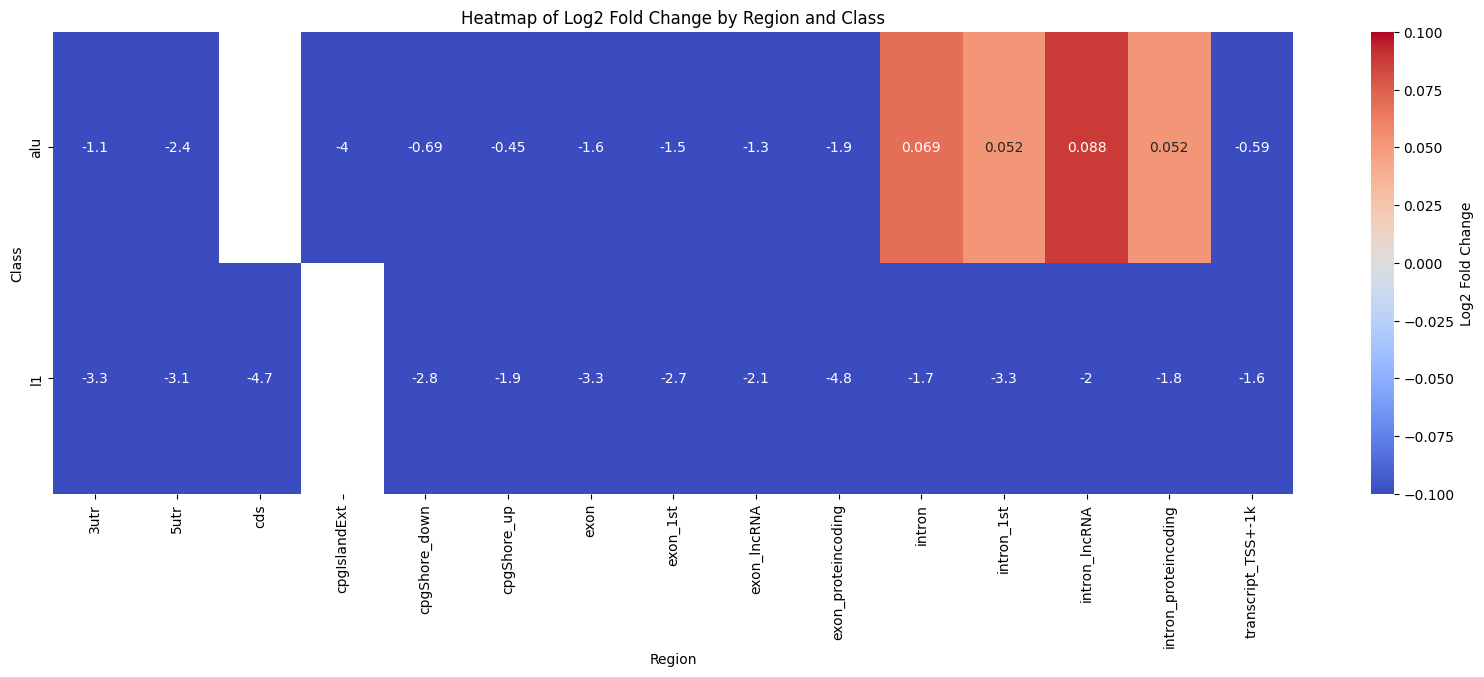

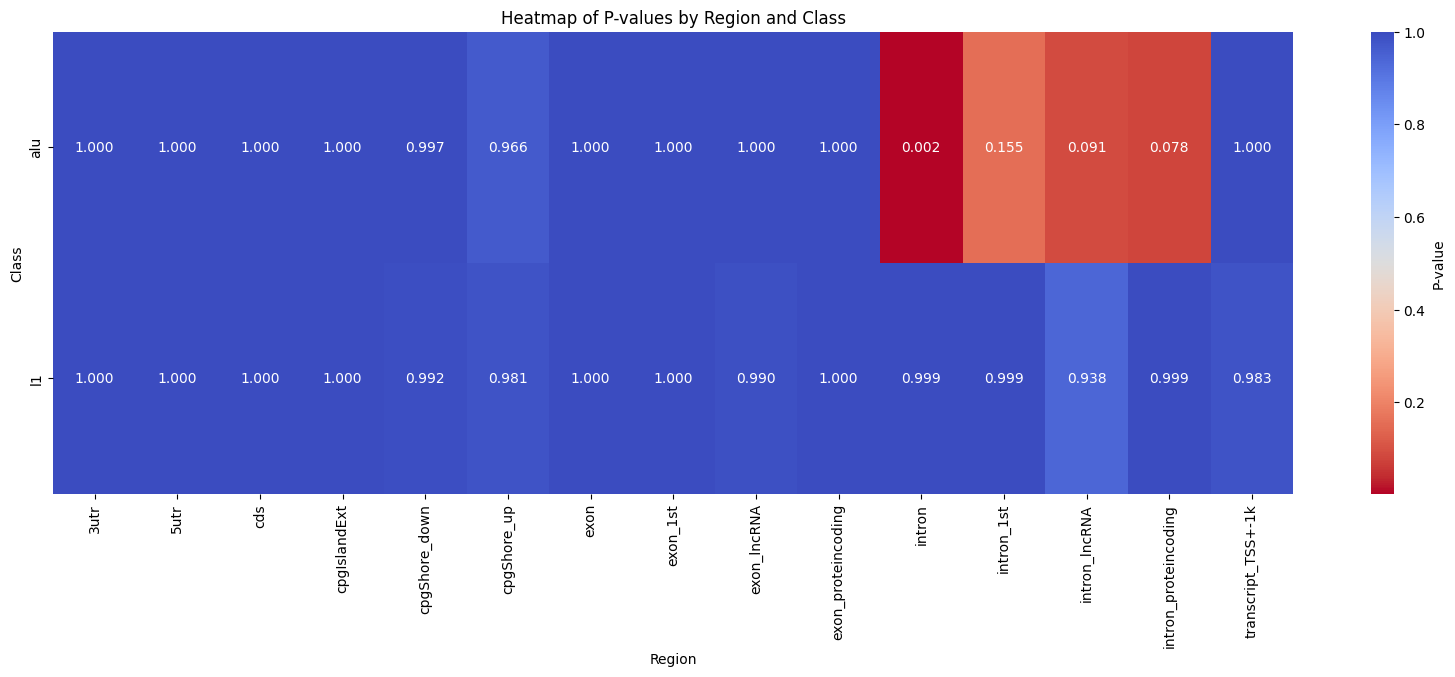

In [140]:
# Step 1: Create a DataFrame
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc,
        'stat_pvalue': stat_sig
})
# Step 2: Pivot the DataFrame to prepare for heatmap plotting
heatmap_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')

# Step 3: Plot the heatmap
plt.figure(figsize=(20, 6))  # Set the figure size
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Log2 Fold Change'})
plt.title('Heatmap of Log2 Fold Change by Region and Class')
plt.ylabel('Class')  # Label for rows
plt.xlabel('Region')  # Label for columns
plt.show()

# Step 2: Pivot the DataFrame to prepare for heatmap plotting
heatmap_data = data.pivot(index='stat_class', columns='stat_region', values='stat_pvalue')

# Step 3: Plot the heatmap
plt.figure(figsize=(20, 6))  # Set the figure size
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",  # Format to show p-values with 3 decimal places
    cmap='coolwarm_r',  # Reverse the color map to highlight lower p-values
    cbar_kws={'label': 'P-value'}
)
plt.title('Heatmap of P-values by Region and Class')
plt.ylabel('Class')  # Label for rows
plt.xlabel('Region')  # Label for columns
plt.show()


In [90]:
#plot stats for insertion vs absences:
emp_ = np.empty(len(l1_df)).astype(str)
emp_.fill('both')
emp_[l1_df['het'].isna()] = 'hom'
emp_[l1_df['hom'].isna()] = 'het'
l1_df['genotype'] = emp_
l1_df.groupby(['me_type', 'genotype']).count()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,chr2,88729338,88734551,intron_proteincoding,protein_coding,+,chr2,88729724,88732765,CZI_abs_1601,3040.0,+,L1HS,"AM3,YF2,YM1,YM3","AF1,AF2,AF3,AM2",absence,3041
1,chr2,88729338,88734551,intron,protein_coding,+,chr2,88729724,88732765,CZI_abs_1601,3040.0,+,L1HS,"AM3,YF2,YM1,YM3","AF1,AF2,AF3,AM2",absence,3041
2,chr2,172314287,172316287,transcript_TSS+-1k,lncRNA,+,chr2,172315267,172321376,CZI_abs_1607,6108.0,+,L1HS,"AF3,YM1",.,absence,1020
3,chr2,172315287,172315408,exon,lncRNA,+,chr2,172315267,172321376,CZI_abs_1607,6108.0,+,L1HS,"AF3,YM1",.,absence,121
4,chr2,172315287,172315408,3utr,lncRNA,+,chr2,172315267,172321376,CZI_abs_1607,6108.0,+,L1HS,"AF3,YM1",.,absence,121
5,chr2,172315287,172315408,exon_1st,lncRNA,+,chr2,172315267,172321376,CZI_abs_1607,6108.0,+,L1HS,"AF3,YM1",.,absence,121
6,chr2,172315287,172315408,exon_lncRNA,lncRNA,+,chr2,172315267,172321376,CZI_abs_1607,6108.0,+,L1HS,"AF3,YM1",.,absence,121
7,chr3,130627370,130634589,intron,"nonsense_mediated_decay,protein_coding",+,chr3,130628732,130634264,CZI_abs_1623,5531.0,+,L1HS,"AF1,AM2,YM1",.,absence,5532
8,chr3,130627370,130634589,intron_proteincoding,protein_coding,+,chr3,130628732,130634264,CZI_abs_1623,5531.0,+,L1HS,"AF1,AM2,YM1",.,absence,5532
9,chr5,133582641,133584641,transcript_TSS+-1k,protein_coding,-,chr5,133583288,133589299,CZI_abs_1661,6010.0,+,L1HS,"AF2,AM1,AM2,AM3,YF2",AF1,absence,1353


,region,count,class
0,transcript_TSS+-1k,4,l1
1,exon_1st,2,l1
2,exon,4,l1
3,5utr,2,l1
4,exon_lncRNA,2,l1
5,3utr,2,l1
6,intron,7,l1
7,intron_1st,1,l1
8,intron_lncRNA,1,l1
9,exon_proteincoding,1,l1


In [ ]:
#insertion only
#======================
l1_out = l1_all_df.groupby(3).count()[0]
alu_out = pd.concat([alu_cgi_df.groupby(13).count()[0],alu_all_df.groupby(13).count()[0]])
l1_out = l1_out.reindex(reg_names, fill_value=0).reset_index()
alu_out = alu_out.reindex(reg_names, fill_value=0).reset_index()
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
l1_out.rename(columns={3:'region', 0:'count'}, inplace=True)
alu_out.rename(columns={13:'region', 0:'count'}, inplace=True)
comb_df = pd.concat([l1_out, alu_out])

stat_region, stat_sig, stat_fc, stat_class = [],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:
        observed_overlap = comb_df[(comb_df['region' ]== reg) & (comb_df['class'] == i)]['count'].values[0]
        expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)]['count'].values)
        from scipy.stats import fisher_exact
        no_overlap_observed = total_observed - observed_overlap
        no_overlap_expected = total_observed - expected_overlap
        # Contingency table
        contingency_table = [
            [observed_overlap, no_overlap_observed],  # Observed
            [expected_overlap, no_overlap_expected]  # Expected
        ]
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')
        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2(observed_overlap/expected_overlap))

In [ ]:
#het only vs hom only
#====================
l1_out = l1_all_df.groupby(3).count()[0]
alu_out = pd.concat([alu_cgi_df.groupby(12).count()[0],alu_all_df.groupby(12).count()[0]])
l1_out = l1_out.reindex(reg_names, fill_value=0).reset_index()
alu_out = alu_out.reindex(reg_names, fill_value=0).reset_index()
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
l1_out.rename(columns={3:'region', 0:'count'}, inplace=True)
alu_out.rename(columns={12:'region', 0:'count'}, inplace=True)
comb_df = pd.concat([l1_out, alu_out])

stat_region, stat_sig, stat_fc, stat_class = [],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:

        observed_overlap = comb_df[(comb_df['region' ]== reg) & (comb_df['class'] == i)]['count'].values[0]
        expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)]['count'].values)

        from scipy.stats import fisher_exact
        
        no_overlap_observed = total_observed - observed_overlap
        no_overlap_expected = total_observed - expected_overlap
        
        # Contingency table
        contingency_table = [
            [observed_overlap, no_overlap_observed],  # Observed
            [expected_overlap, no_overlap_expected]  # Expected
        ]
        
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')
        
        # print("Contingency Table:")
        # print(contingency_table)
        
        # print(f"Odds Ratio: {odds_ratio}, P-value: {p_value}")

        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2(observed_overlap/expected_overlap))

In [ ]:
#truncated vs full length
#=========================
l1_out = l1_all_df.groupby(3).count()[0]
alu_out = pd.concat([alu_cgi_df.groupby(12).count()[0],alu_all_df.groupby(12).count()[0]])
l1_out = l1_out.reindex(reg_names, fill_value=0).reset_index()
alu_out = alu_out.reindex(reg_names, fill_value=0).reset_index()
l1_out['class'] = 'l1'
alu_out['class'] = 'alu'
l1_out.rename(columns={3:'region', 0:'count'}, inplace=True)
alu_out.rename(columns={12:'region', 0:'count'}, inplace=True)
comb_df = pd.concat([l1_out, alu_out])

stat_region, stat_sig, stat_fc, stat_class = [],[],[],[]
for i in ['alu', 'l1']:
    if i == 'alu': total_observed = len(alu_df)
    if i == 'l1': total_observed = len(l1_df)
    for reg in reg_names:

        observed_overlap = comb_df[(comb_df['region' ]== reg) & (comb_df['class'] == i)]['count'].values[0]
        expected_overlap = np.mean(tot_df[(tot_df['region' ]== reg) & (tot_df['class'] == i)]['count'].values)

        from scipy.stats import fisher_exact
        
        no_overlap_observed = total_observed - observed_overlap
        no_overlap_expected = total_observed - expected_overlap
        
        # Contingency table
        contingency_table = [
            [observed_overlap, no_overlap_observed],  # Observed
            [expected_overlap, no_overlap_expected]  # Expected
        ]
        
        # Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')
        
        # print("Contingency Table:")
        # print(contingency_table)
        
        # print(f"Odds Ratio: {odds_ratio}, P-value: {p_value}")

        stat_region.append(reg)
        stat_class.append(i)
        stat_sig.append(p_value)
        stat_fc.append(np.log2(observed_overlap/expected_overlap))

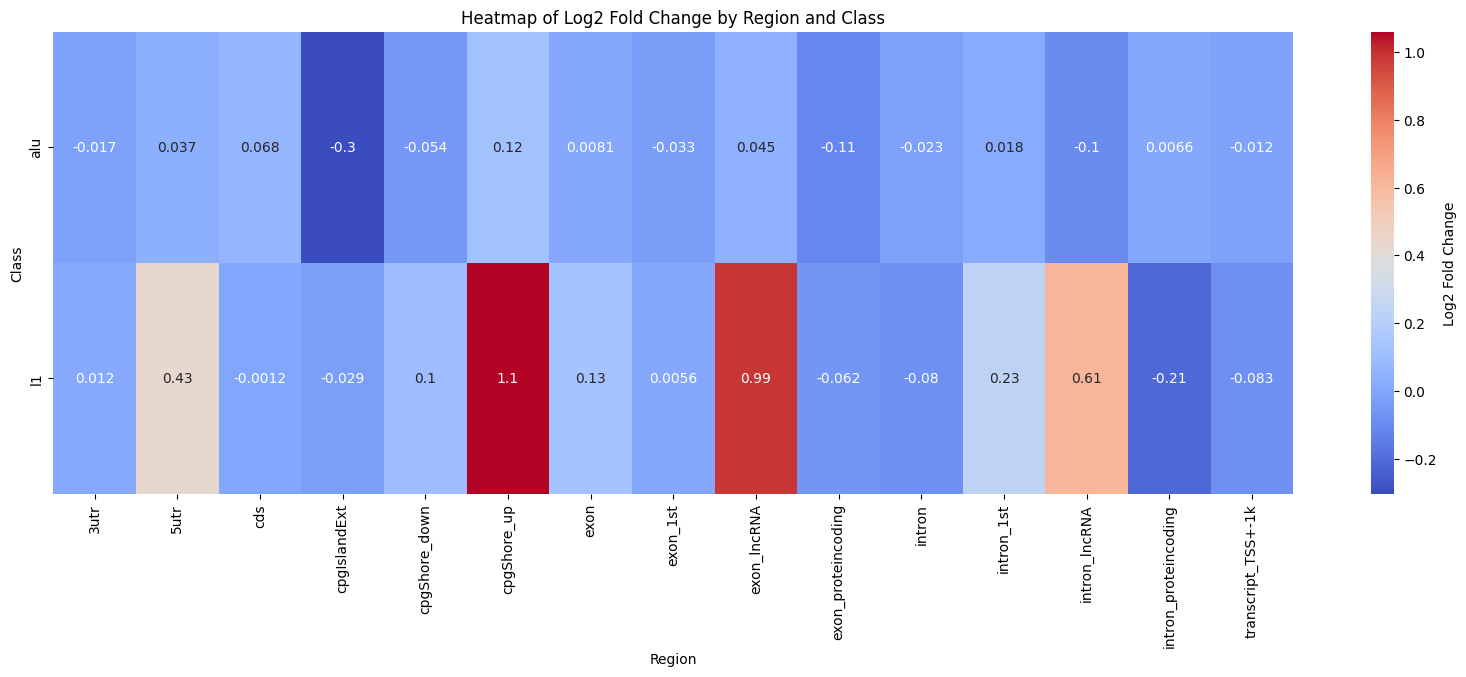

In [351]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a DataFrame
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_fc': stat_fc
})

# Step 2: Pivot the DataFrame to prepare for heatmap plotting
heatmap_data = data.pivot(index='stat_class', columns='stat_region', values='stat_fc')

# Step 3: Plot the heatmap
plt.figure(figsize=(20, 6))  # Set the figure size
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Log2 Fold Change'})
plt.title('Heatmap of Log2 Fold Change by Region and Class')
plt.ylabel('Class')  # Label for rows
plt.xlabel('Region')  # Label for columns
plt.show()

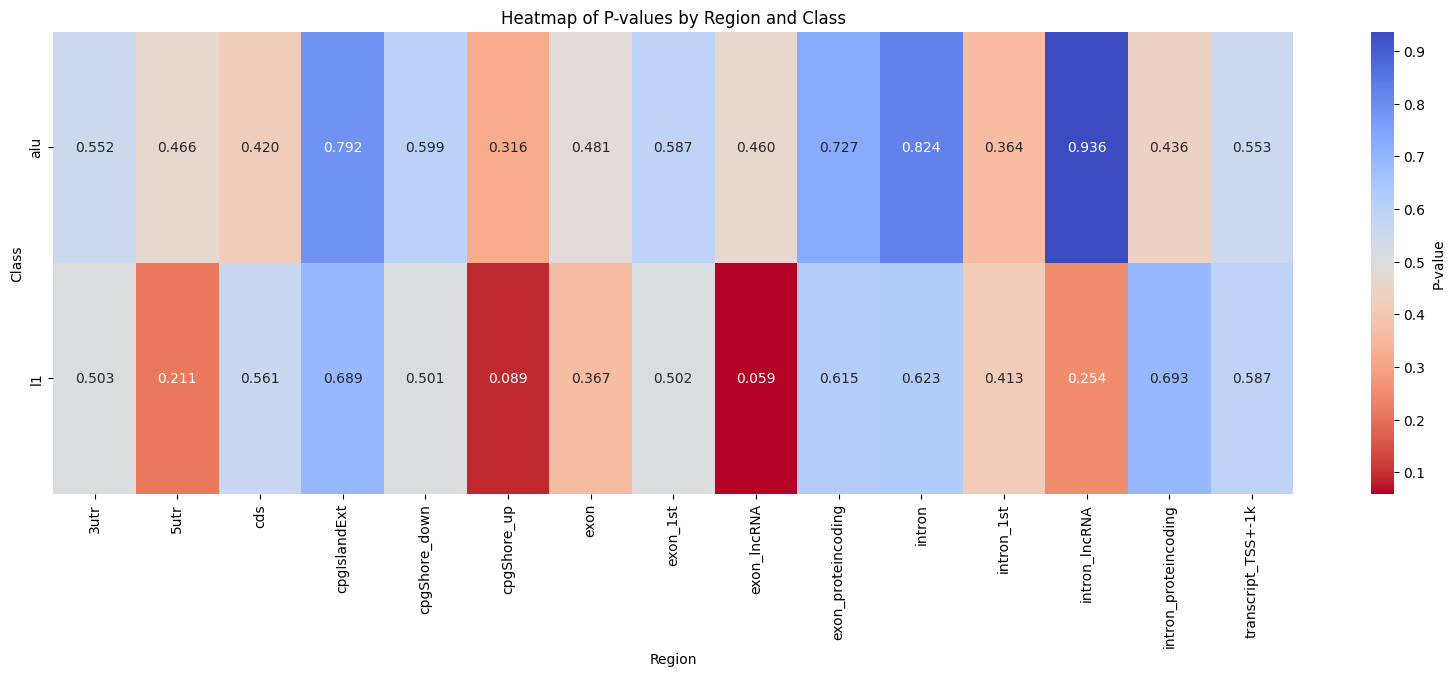

In [352]:
# Step 1: Create a DataFrame
data = pd.DataFrame({
    'stat_region': stat_region,
    'stat_class': stat_class,
    'stat_pvalue': stat_sig
})

# Step 2: Pivot the DataFrame to prepare for heatmap plotting
heatmap_data = data.pivot(index='stat_class', columns='stat_region', values='stat_pvalue')

# Step 3: Plot the heatmap
plt.figure(figsize=(20, 6))  # Set the figure size
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",  # Format to show p-values with 3 decimal places
    cmap='coolwarm_r',  # Reverse the color map to highlight lower p-values
    cbar_kws={'label': 'P-value'}
)
plt.title('Heatmap of P-values by Region and Class')
plt.ylabel('Class')  # Label for rows
plt.xlabel('Region')  # Label for columns
plt.show()
